# Load Package

In [4]:
import configparser
conf_dir = '/home/cdsadmin/AMT/src/conf/config.ini'
cfg = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
cfg.read(conf_dir)
#logging
import logging
import logging.config
logging.config.fileConfig(str(cfg['common']['log_config']))

# default package 
import numpy as np
import pandas as pd 
import time,os,psutil
import IPython
from datetime import datetime
from IPython.lib import kernel
import collections
import itertools
import pickle,ast,joblib
## hana DB client 
from hdbcli import dbapi 
from IPython.core.display import display, Image
import multiprocessing
import sqlite3

#visualization 
from tqdm.auto import tqdm
from sklearn.metrics import plot_confusion_matrix

# scale & eda
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from collections import Counter

# feature selection 
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# split data & sampling for imbalanced set
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from multi_imbalance.ensemble          import ovo
from multi_imbalance.resampling.soup   import SOUP
from multi_imbalance.resampling.static_smote import SMOTE
from multi_imbalance.utils.data        import construct_flat_2pc_df
from multi_imbalance.utils.min_int_maj import maj_int_min
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling  import TomekLinks,ClusterCentroids,EditedNearestNeighbours,NeighbourhoodCleaningRule,RandomUnderSampler

# predict model
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier,OutputCodeClassifier
from catboost import CatBoostClassifier
from sklearn  import svm
from sklearn.naive_bayes import GaussianNB
from vecstack import stacking
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier,XGBRFClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import StratifiedShuffleSplit,RandomizedSearchCV

#confusion matrix (measure)
from sklearn.metrics import confusion_matrix,precision_score,recall_score,\
                              f1_score,accuracy_score,roc_auc_score,roc_curve,auc,\
                              classification_report,precision_recall_curve
from sklearn.model_selection import cross_val_score,KFold
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

#---------------------------------------------------------
# ■ setting configuration (db_connectionm, load_model)
#---------------------------------------------------------
global HOST,PORT,DB_ID,DB_PW,MODEL_DIR
HOST  = cfg['dbconnect_dev']['host']
PORT  = int(cfg['dbconnect_dev']['port'])
DB_ID = cfg['dbconnect_dev']['ID']
DB_PW = cfg['dbconnect_dev']['PW']
MODEL_DIR  = cfg['Timing']['MODEL_DIR']
MODEL_NAME = cfg['Timing']['MODEL_NAME']
#----------------------------------------------------------
# ■logging
#----------------------------------------------------------
logger = logging.getLogger('timing_train')
#----------------------------------------------------------
# pd.set_option('display.max_rows', 600)
# pd.set_option('display.max_columns', 90)
# pd.set_option('display.width', 1000)
# pd.set_option('mode.chained_assignment',  None) # <==== turn off warining message 

['/home/cdsadmin/AMT/src/conf/config.ini']

#  Load Data  (MultiProcessing)

In [4]:
## --------------------------------------------------
## load_data
## --------------------------------------------------
def check_pid():
    connection_file_path = kernel.get_connection_file()
    connection_file      = os.path.basename(connection_file_path)
    kernel_id            = connection_file.split('-', 1)[1].split('.')[0]
    print('■ [PID]          : %s '%os.getpid())
    print('■ [Jupyter path] : %s' %os.getcwd())
    print('■ [Kernel ID]    : %s' %kernel_id)

def timecheck(start):
    learn_time = time.time() - start
    train_time = round(learn_time/60)  
    print("소요시간 :",  round(learn_time,-1), "초", "  (",train_time, "분 )\n")
    return learn_time,train_time
    
def DB_Connection() :
    conn=dbapi.connect(HOST,PORT,DB_ID,DB_PW)
    return conn

def Datachunk_range(rownum_sql) :
    conn = DB_Connection()
    cnt = pd.read_sql(rownum_sql, conn)
    key = int(cnt.values)
    print('Data  count : %s'%key)
    rm  = key % n_core
    ## Split row_num / n_core 
    arg_list_flt =[i for i in range(0,key,int(key/n_core))]
    ## last sequence add remainder 
    if rm > 0:
        arg_list_flt[len(arg_list_flt)-1] = arg_list_flt[len(arg_list_flt)-1]+rm
    else:
        arg_list_flt.append(arg_list_flt[-1]+arg_list_flt[1])
    conn.close()        
    return arg_list_flt,rm

def SQL_worker(num):    
    b = int(arg_list.index(num))-1
    if (int(arg_list.index(num)) == 0) :
        result = None
    else :
        start_num = int(arg_list[b])+1
        end_num   = int(num)
        print('start_num : %s | end_num : %s'%(start_num,end_num))
        sql =f'''
                SELECT *
                FROM (SELECT   ROW_NUMBER() OVER (ORDER BY CUST_ID ASC) AS ROW_NUM
                             , *
                      FROM  {db_name}) T1
                WHERE T1.ROW_NUM between {start_num} and {end_num}
              '''
        conn   = DB_Connection()
        result = pd.read_sql(sql, conn)
        conn.close()
        result = result[result['CLASS_CAT'].isna() == False]
    return result

def multiprocesser(arg_list) : 
    check_pid()
    print('\nstart_arg_list : %s \n'%arg_list)
    p = multiprocessing.Pool(processes = n_core)
    data = p.map(SQL_worker, arg_list) 
    p.close()
    p.join()
    result = pd.concat(data)
    return result   

def check_cpu_percent(num):
    cpu_cnt = len(psutil.Process().cpu_affinity())
    c_list = psutil.cpu_percent(percpu=True)
    available_cpu_cnt = len([i for i in c_list if i < 1])
    n_core = np.trunc(available_cpu_cnt/num)
    print('[ total_cpu_cnt ] : ',cpu_cnt)
    print('[ available_cpu_cnt ] : ',available_cpu_cnt)
    return int(n_core)

## Load Feather data

In [5]:
def load_feather_data(filename):
    df = pd.read_feather(filename)
    if len(set(df.columns.tolist())&set(['ROW_NUM'])) > 0:
        df_1 = df.drop(columns=['ROW_NUM'],inplace=False)
    else :
        df_1 = df
    return df_1

def load_model_result(X_test,Y_test,mdl_nm):    
    mdl_name = mdl_nm
    print('model_name : %s'%mdl_name)
    clf         = load_model(mdl_name+'.pkl')
    feature_list =  ml_list_2.loc[ml_list_2['MODEL_DIR'] == mdl_name,'FEATURE_LIST']
    x           = ast.literal_eval(feature_list)
    feature     = [n.strip() for n in x]
    print('■ Feature : %s'%feature)
    print('■ Feature Count : %s'%len(feature))
    X_test      = X_test.reindex(columns=feature)
    y_pred      = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)

    print(classification_report(Y_test, y_pred, digits=3))
    
# X_train = load_feather_data('temp/X_train_1211.ftr')
# Y_train = load_feather_data('temp/Y_train_1211.ftr')
# X_test  = load_feather_data('temp/X_test_1211.ftr')
# Y_test  = load_feather_data('temp/Y_test_1211.ftr')
# resampled_X = load_feather_data('temp/SOUP_resampled_X.ftr')
# resampled_Y = load_feather_data('temp/SOUP_resampled_y.ftr')
# print('X_train Shape : %s'%X_train.shape[0])
# print('X_test  Shape : %s'%X_test.shape[0])
# print('C1_train : %s / C1_test : %s'%(len(Y_train[Y_train['CLASS_CAT'] == 1]),len(Y_test[Y_test['CLASS_CAT'] == 1])))
# print('C2_train : %s / C2_test : %s'%(len(Y_train[Y_train['CLASS_CAT'] == 2]),len(Y_test[Y_test['CLASS_CAT'] == 2])))
# print('C3_train : %s / C3_test : %s'%(len(Y_train[Y_train['CLASS_CAT'] == 3]),len(Y_test[Y_test['CLASS_CAT'] == 3])))
# print('SOUP resampled C1 : %s'%len(resampled_Y[resampled_Y['CLASS_CAT'] == 1]))
# print('SOUP resampled C2 : %s'%len(resampled_Y[resampled_Y['CLASS_CAT'] == 2]))
# print('SOUP resampled C3 : %s'%len(resampled_Y[resampled_Y['CLASS_CAT'] == 3]))
# last_feature = ['RFM_LV_DI_FRESH2', 'LAST_OFFLINE_DIFF_DAYS', 'SHOP_SEG_5', 'PURCHS_CYCLE_CHG', 'PRDT_DCODE42_CNT', 'PRDT_DCODE60_CNT', 'EMT_MALL_LAST_PUCHS_DIFF', 'PRDT_DCODE40_CNT', 'PRDT_DCODE11_CNT', 'PRDT_DCODE10_CNT', 'RFM_LV_DI_FASHION', 'PRDT_DCODE30_CNT', 'RECENT_1M_SALES_INDEX', 'PURCHS_CYCLE', 'RFM_LV_DI_MOLLYS', 'RFM_LV_DI_CULTR', 'SHOP_SEG_10', 'MAX_PRDT_PURCHS_CYCLE', 'MAIN_PRDT_ARRVL_RT_DIFF_ABS', 'PRDT_DCODE41_CNT', 'RFM_LV_DI_PEACOCK', 'PREFER_PRDT_ARRVL_RT_DIFF_ABS', 'SHOP_SEG_4', 'EMT_MALL_VISIT_YN', 'PRDT_DCODE70_CNT', 'RFM_LV_DI_HNB', 'TOT_FREQUENCY_CNT', 'PRDT_DCODE50_CNT', 'SHOP_SEG_2', 'PURCHS_CYCLE_ARRVL_DIFF_ABS', 'RFM_LV_DI_FRESH1', 'PURCHS_CYCLE_ARRVL_RT', 'MIN_PRDT_PURCHS_CYCLE', 'TOP2_STR_DSTNC', 'PRDT_DCODE20_CNT', 'SHOP_SEG_8', 'SHOP_SEG_3', 'RFM_LV_DI_ELEC', 'PURCHS_CYCLE_REGUL_YN', 'RFM_M_SCORE', 'LAST_OFFLINE_BIZTP_DIFF_DAYS', 'TOP1_STR_DSTNC', 'SHOP_SEG_6', 'RFM_F_SCORE', 'LAST_ONLINE_DIFF_DAYS', 'SHOP_SEG_9', 'RFM_LV_DI_LIVING', 'RFM_LV_DI_PRCS', 'USEFL_POINT', 'PURCHS_VISIT_CHG_RT_AVG_6M', 'SHOP_SEG_7', 'SHOP_SEG_1', 'DAVG_PURCHS_AMT_EXC_ELEC', 'PRDT_DCODE51_CNT', 'RFM_LV', 'RECENT_3M_FREQUENCY_DIFF_RT']

# Data Preprocessing 

## Feature Sclicing & Make Derived Variable

In [6]:
def data_summary(df):
    des1 = df.describe().T.reset_index()
    des2 = df.isnull().sum().to_frame(name = 'missing').reset_index()
    des2['null_cnt_rt'] = round((des2['missing']/df.shape[0])*100,1)
    des2.columns = ['feature','null_cnt','null_cnt_rt']
    summary= pd.merge(des1, des2, left_on='index', right_on='feature', how='left')
    return summary

def get_dummy(df):
    dummy_df = pd.get_dummies(df['SHOP_DNA_SEG_ID'], prefix='SHOP_SEG')
    df = df.loc[:, df.columns != 'SHOP_DNA_SEG_ID']
    result = pd.concat([df,dummy_df],axis=1)
    dummy_cols_list = dummy_df.columns.tolist()
    return result,dummy_cols_list


def feature_slicing(summary_df):
    global Y_label,key_x,binary_x
    global event_feature,next_event_feature,derived_feature
    global arrvl_rt_diff_abs_cols,diff_days_cols
    global feature_x,zero_x
    
    Y_label                  = ['CLASS_CAT']
    key_x                    = ['ROW_NUM','CUST_ID','CLASS_CAT']
    #dummy variables / binary variables
    binary_x                 = ['EMT_MALL_VISIT_YN','PURCHS_CYCLE_REGUL_YN']
    # default feature(all feature - label feature)
    feature_x                = [ 'TOT_FREQUENCY_CNT','RFM_LV','RFM_F_SCORE','RFM_M_SCORE'
                                ,'DAVG_PURCHS_AMT_EXC_ELEC','RECENT_3M_FREQUENCY_DIFF_RT'
                                ,'PURCHS_CYCLE','PURCHS_CYCLE_ARRVL_RT','PURCHS_CYCLE_CHG','PURCHS_CYCLE_REGUL_YN'
                                ,'PURCHS_VISIT_CHG_RT_AVG_6M','TOP1_STR_DSTNC','TOP2_STR_DSTNC'
                                ,'USEFL_POINT','EMT_MALL_VISIT_YN','EMT_MALL_LAST_PUCHS_DIFF'
                                ,'LAST_ONLINE_DIFF_DAYS','LAST_OFFLINE_DIFF_DAYS','LAST_OFFLINE_BIZTP_DIFF_DAYS'
                                ,'RECENT_1M_SALES_INDEX'
                                ,'RFM_LV_DI_FRESH1','RFM_LV_DI_FRESH2','RFM_LV_DI_PEACOCK'
                                ,'RFM_LV_DI_PRCS','RFM_LV_DI_HNR','RFM_LV_DI_LIVING'
                                ,'RFM_LV_DI_MOLLYS','RFM_LV_DI_ELEC_CULTR','RFM_LV_DI_FSHN'
                                ,'MAIN_PRDT_ARRVL_RT_DIFF_ABS','PREFER_PRDT_ARRVL_RT_DIFF_ABS'
                                ,'MIN_PRDT_PURCHS_CYCLE','MAX_PRDT_PURCHS_CYCLE'
                                ,'PRDT_DCODE10_CNT','PRDT_DCODE11_CNT','PRDT_DCODE20_CNT'
                                ,'PRDT_DCODE30_CNT','PRDT_DCODE40_CNT','PRDT_DCODE41_CNT'
                                ,'PRDT_DCODE42_CNT','PRDT_DCODE50_CNT','PRDT_DCODE60_CNT']
    
    # using  Derived Variable (each event x future event days) 
    event_feature            = [ 'CLDR_EVENT_PRE_UNITY','CLDR_EVENT_PRE_TREDI','PURCHS_WEND_HLDY']
    next_event_feature       = [ 'EVENT_DAYS_CNT','TREDI_DAYS_CNT','HOLI_DAYS_CNT']
    derived_feature          = ['EVENT_PREFE_UNITY_INDEX','TREDI_PREFE_UNITY_INDEX','HOLI_PREFE_UNITY_INDEX']
    # days diff values 
    diff_days_cols           = [ 'EMT_MALL_LAST_PUCHS_DIFF', 'LAST_ONLINE_DIFF_DAYS','LAST_OFFLINE_DIFF_DAYS', 'LAST_OFFLINE_BIZTP_DIFF_DAYS']
    # arrvl_rt values
    arrvl_rt_diff_abs_cols   = [ 'MAIN_PRDT_ARRVL_RT_DIFF_ABS','PREFER_PRDT_ARRVL_RT_DIFF_ABS'
                                ,'MAX_PRDT_PURCHS_CYCLE'      ,'MIN_PRDT_PURCHS_CYCLE','PURCHS_CYCLE_ARRVL_RT']
    # fillna(0) - except diff days features and prdt_arrvl_rt_diff features
    zero_x                    =  list(set(feature_x)-set(diff_days_cols)-set(arrvl_rt_diff_abs_cols))
    
# Event Feature
def make_Derived_Variable(df):
    global event_cols_list
    df[zero_x]      = df[zero_x].fillna(0)
    event_cols_list = []
    # max val for diff variable replace isnull
    max_val = np.max(summary_df.loc[(summary_df['index'].isin(arrvl_rt_diff_abs_cols+diff_days_cols)),'max'].values)+30
    df[arrvl_rt_diff_abs_cols+diff_days_cols] = df[arrvl_rt_diff_abs_cols+diff_days_cols].fillna(max_val)
    df = df.round(1)
    # make derived variable (holidays prefer score(0~4)  * future event days )
    for i in range(0,3):
        for j in range(0,3):
            class_cat  = 'C'+str(i+1)+'_'
            cols       = event_feature[j]
            name       = class_cat+derived_feature[j]
            match_cols = class_cat+next_event_feature[j]
            df[name]   = (df[cols]*df[match_cols])
            df[name]   = df[name]/(np.max(df[name])*2)
            event_cols_list.append(class_cat+next_event_feature[j])
            event_cols_list.append(cols)
            event_cols_list.append(name)
            event_cols_list.append(match_cols)
    df = df.fillna(0)
    return df

## EDA - (1) Check distribution

In [7]:
# check Distribution each Feature
def EDA_distributions(df,col_list):   
    for column in col_list:
        cc = [column]
#         display(df_1.groupby(['CLASS_CAT'])[cc].describe())
        sns.catplot(x='CLASS_CAT', y=cc[0], order=[1,2,3,4], data=df)
        sns.lmplot(data=df,
                   x= column,
                   y='CLASS_CAT',
                   hue='CLASS_CAT',
                   col='CLASS_CAT')
                
# detect outliers (iQR)
def detect_outliers(df):
    outlier_cols = []
    perc_list    = []
    upper_limit  = []
    lower_limit  = []
    outlier_cnt  = []
    all_cnt      = []
    for col, data in df.items():
        q1  = data.quantile(0.25)
        q3  = data.quantile(0.75)
        iqr = q3 - q1
        scale = 1.5
        lower = q1 - scale * iqr
        upper = q3 + scale * iqr
        v_col = data[(data < lower) | (data > upper)]
        perc  = ( np.shape(v_col)[0] / np.shape(df)[0] )* 100.0
        print("Column %s outliers [ %s / %s ] = %.2f%%" % (col,np.shape(v_col)[0],np.shape(df)[0], perc))
        outlier_indices = np.shape(v_col)[0]
        if (outlier_indices == 0):
            print('%s 변수에 탐지된 이상치는 없습니다.\n'%col)
        else:
            print('%s 변수에 탐지된 이상치 데이터의 개수  : %s\n'%(col,outlier_indices))
            outlier_cols.append(col)
            perc_list.append(perc)
            outlier_cnt.append(np.shape(v_col)[0])
            all_cnt.append(np.shape(df)[0])
            lower_limit.append(lower)
            upper_limit.append(upper)
    result = pd.DataFrame({'outlier_list' : outlier_cols,
                           'all_cnt' : all_cnt,
                           'outlier_cnt' : outlier_cnt,
                           'perc' : perc_list,
                           'upper_limit':upper_limit,
                           'lower_limit':lower_limit})
    result = result.sort_values(by=['perc'],ascending = False)  
    return result

def check_skewed(df):
    skew_df =  df.skew()
    skew_df = abs(skew_df).sort_values(ascending=False)
    skew_df = pd.DataFrame(skew_df).reset_index()
    skew_df.columns = ['feature','skewed']
#     return sked_df[sked_df >= 2]
    return skew_df

def make_sample_data(df,Y_label):
    c1_sample = df[df[str(Y_label[0])] == 1].sample(1000)
    c2_sample = df[df[str(Y_label[0])] == 2].sample(1000)
    c3_sample = df[df[str(Y_label[0])] == 3].sample(1000)
    sample_df = pd.concat([c1_sample,c2_sample,c3_sample])
    return sample_df 

## EDA - (2) Feature Scaling

In [8]:
# using IQR 
def robust_scaling(df,cols):
    X = df[cols]
    robustScaler = RobustScaler()
    print(robustScaler.fit(X))
    robustScaled_train_x = robustScaler.transform(X)
    scaled_df = pd.DataFrame(robustScaled_train_x,columns=cols)
    return scaled_df

# Data Scaling
def log_scaling(df,cols_list):
    input_df = df
    for col in cols_list:
        print(col)
        print('before : ',df[col].skew())
#         after_boxcox = stats.boxcox(input_df[col]+1)[0]
        aa = np.log(input_df[col])
        input_df[col] = pd.Series(aa)
        print('after : ',input_df[col].skew())
#         plt.subplot(1, 2, 2)
        fig = sns.distplot(input_df[col])
        fig.set_xlabel(col)
        plt.show()

## EDA - (3) Feature Importance

In [9]:
#Meta-transformer for selecting features based on importance weights.
def Feature_Importance(clf,df,cols,cat,fuc):
    print(df['CLASS_CAT'].unique())
    df['CLASS_CAT'] = df['CLASS_CAT'].map(fuc)
    count_class = str(collections.Counter(df['CLASS_CAT']))
    df = df.fillna(0)
    X = df[cols]
    y = df['CLASS_CAT']
    start = time.time()
    print('PI')
    print(count_class)
    check_pid()
    
    clf.fit(X,y)
    result     = permutation_importance(clf, X, y, n_repeats=3, random_state=42, n_jobs=10)
    sorted_idx = result.importances_mean.argsort()
    
    # visualiazation Permutation Importance
    fig, ax = plt.subplots(figsize=(20,20))
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels = X.columns[sorted_idx] )
    ax.set_title("Permutation_impotances_Test",fontsize=24)
    plt.yticks(fontsize=16)
    fig.tight_layout()
    plt.show()
    importance_t = result.importances_mean[sorted_idx]
    PI_feature = X.columns[sorted_idx]
    
    df_1 = pd.DataFrame(importance_t,PI_feature).reset_index()
    df_1.columns = ['FEATURE','IMPORTANCE']
    last_pi = df_1[df_1['IMPORTANCE'] > 0.00000]
    display(last_pi.sort_values('IMPORTANCE',ascending=False))
    last_pi['CLASS_CAT']           = cat
    last_pi['ML']                  = str(clf).split("(")[0]
    last_pi['COUNT']               = count_class
    last_pi['INPUT_FEATURE']       = str(cols)
    last_pi['INPUT_FEATURE_COUNT'] = len(cols)
    last_pi['IMPORTANCE_FEATURE_COUNT'] = len(last_pi['FEATURE'].values.tolist())
    last_pi= last_pi.reindex(['CLASS_CAT', 'COUNT','INPUT_FEATURE','ML','FEATURE','IMPORTANCE','INPUT_FEATURE_COUNT','IMPORTANCE_FEATURE_COUNT'], axis="columns")
    display(last_pi)
#     insert_pi_table('YSR_PI_RESULT',last_pi)
    timecheck(start)
    return last_pi

# get importance
def PI_score(result,column):
    check_pid()
    sorted_idx = result.importances_mean.argsort()
    importance = result.importances_mean[sorted_idx]
    display(importance)
    df = pd.DataFrame(importance,column).reset_index()
    df.columns = ['feature','importance']
    display(df.sort_values('importance',ascending=False))
    return df

def selectfrommodel_importance(df,cols):
    start = time.time()
    print('selectfrommodel')
    check_pid()
    f = lambda x: 0 if x == 4 else 1
    df['CLASS_CAT'] = df['CLASS_CAT'].map(f)
    X = df[cols]
    y = df['CLASS_CAT']
    input_cols = X.columns
    lgb_selector   = SelectFromModel(estimator=LGBMClassifier(n_job=4)).fit(X, y)
    xgb_selector   = SelectFromModel(estimator=XGBClassifier()).fit(X, y)
    
    feature_list = list(input_cols[lgb_selector.get_support()])+list(input_cols[xgb_selector.get_support()])
    print('LightGBM : ',input_cols[lgb_selector.get_support()])
    print('xgboost  : ',input_cols[xgb_selector.get_support()])
    learn_time = time.time() - start
    train_time = round(learn_time/60)  
    print("학습시간 :",  round(learn_time,-1), "초", "  (", round(learn_time/60), "분 )\n")
    return list(set(feature_list))

# Imbalanced Set 

### dimension reduction for vector visualization and filtering majority class
#### PCA   : principal Components Analysis 
#### TSNE : T-Stochastic Neighbor Embedding(t-SNE) 

In [10]:
def scatterplot(df,x_col,y_col,label_col):
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=label_col, style=label_col)

#pca
def Principal_Components(df,cols):
    check_pid()
    X_train = df[cols]
    label   = df[key_x]
    pca     = PCA(n_components=2,random_state=0) 
    printcipalComponents = pca.fit_transform(X_train)
    display(pca.explained_variance_ratio_)
    principalDf          = pd.DataFrame(data=printcipalComponents, columns = ['PCA1', 'PCA2'])
    pca_df  = pd.concat([principalDf,label.reset_index()],axis=1)
    scatterplot(pca_df,"PCA1","PCA2","CLASS_CAT")
    return pca_df

def T_stochastic_Neighbor_Embedding(df,cols):
    check_pid()
    df_1 = make_sample_data(df)
    X = df_1[cols]
    y = df_1['CLASS_CAT']
    T_model = TSNE(perplexity=30)
    transformed = T_model.fit_transform(X)
    xs = transformed[:,0]
    ys = transformed[:,1]
    tsne_df = pd.concat([pd.DataFrame(transformed),y],axis=1)
    tsne_df.columns = ['T_COMP1','T_COMP2','CLASS_CAT']
    scatterplot(tsne_df,"T_COMP1","T_COMP2","CLASS_CAT")
    return tsne_df

#### Sampling : SMOTE,SOUP,Tomeklink,CentroidCluster

In [11]:
# SOUP(Similarity Over-sampling and Undersampling Preprocessing)
def Similarity_Over_Under_samplig(X_train,Y_train):
    import seaborn as sns
    import matplotlib.pyplot as plt 
    global sampling
    sampling = 'SOUP'
    X = X_train
    y = Y_train
    clf = SOUP(maj_int_min={'maj':[3], 'min': [1,2]}, shuffle=False)
    resampled_X, resampled_y = clf.fit_resample(X, y)
#     print('Before C1 : %s ==> After C1 : %s'%(len(y[y==1]),len(resampled_y[resampled_y==1])))
#     print('Before C2 : %s ==> After C2 : %s'%(len(y[y==2]),len(resampled_y[resampled_y==2])))
#     print('Before C3 : %s ==> After C3 : %s'%(len(y[y==3]),len(resampled_y[resampled_y==3])))
    
    n = len(Counter(y).keys())
    p = sns.color_palette("husl", n)
    print(n)

    pca = PCA(n_components=2)
    pca.fit(X)

    fig, axs = plt.subplots(ncols=2, nrows=2)
    fig.set_size_inches( 16, 10)
    axs = axs.flatten()

    axs[1].set_title("Base")
    sns.countplot(y, ax=axs[0], palette=p)
    X_pca = pca.transform(X)
    df = construct_flat_2pc_df(X_pca, y)
    sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[1], legend='full', palette=p)

    axs[3].set_title("SOUP")
    sns.countplot(resampled_y, ax=axs[2],palette=p)
    X_SOUP_pca = pca.transform(resampled_X)
    df_1 = construct_flat_2pc_df(X_SOUP_pca, resampled_y)
    sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df_1, alpha=0.7, ax=axs[3], legend='full', palette=p)
    
    return resampled_X, resampled_y

def Over_borderline1_SMOTE(X_train,Y_train):
    global sampling
    sampling = 'Borderline1_SMOTE'
    X = X_train
    y = Y_train

    sm = BorderlineSMOTE(sampling_strategy='auto',
                        random_state=10,
                        k_neighbors=5,
                        n_jobs=20)

    X_resampled, y_resampled = sm.fit_sample(X_train,Y_train)
    print('Before OverSampling, the shape of train_X: {} \n'.format(X_train.shape))
    print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
    print("After OverSampling, counts of label '1': {}".format(sum(y_resampled==1)))
    print("After OverSampling, counts of label '2': {}".format(sum(y_resampled==2)))
    print("After OverSampling, counts of label '3': {}".format(sum(y_resampled==3)))
    return X_resampled, y_resampled
    
def Under_tomek_links(X_train,Y_train):
    X = X_train
    y = Y_train
    tl = TomekLinks(sampling_strategy=[3],n_jobs=20)
    X_resampled, y_resampled = tl.fit_resample(X_train,Y_train)
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_resampled))
    return X_resampled, y_resampled

def Under_Cluster_Centroid(X_train,Y_train):
    X = X_train
    y = Y_train
    cc = ClusterCentroids(sampling_strategy='majority',n_jobs=20)
    X_resampled, y_resampled = cc.fit_resample(X_train,Y_train)
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_resampled))
    return X_resampled, y_resampled

def Under_ENN(X_train,Y_train):
    X = X_train
    y = Y_train
    enn = EditedNearestNeighbours(sampling_strategy=[3],n_jobs=20)
    X_resampled, y_resampled = enn.fit_resample(X_train,Y_train)
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_resampled))
    return X_resampled, y_resampled

def Under_NCR(X_train,Y_train):
    check_pid()
    X = X_train
    y = Y_train
    ncr = NeighbourhoodCleaningRule(sampling_strategy=[3],n_jobs=20)
    X_resampled, y_resampled = ncr.fit_resample(X_train,Y_train)
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_resampled))
    return X_resampled, y_resampled
    
def Under_Random(X_train,Y_train):
    check_pid()
    X = X_train
    y = Y_train
    ncr = RandomUnderSampler(sampling_strategy='auto')
    X_resampled, y_resampled = ncr.fit_resample(X_train,Y_train)
    print('Original dataset shape %s' % Counter(y))
    print('Resampled dataset shape %s' % Counter(y_resampled))
    return X_resampled, y_resampled

# Modeling 

## Split dataset & Save/Load model

In [12]:
# convert to non-target label to '0' and target label to '1'
def label_convert_binary(df,non_target_label,cat):
    f = lambda x: 0 if x == non_target_label else 1
    df['CLASS_CAT'] = df['CLASS_CAT'].map(f)
    return df


def merge_Y_label(df,label_df):
    df = df.reset_index()
    Y_test_key = pd.merge(df,label_df[['CUST_ID','ROW_NUM']],how='inner',left_on='ROW_NUM',right_on = 'ROW_NUM')
    return Y_test_key

#Split dataset (default = train(80%),test(20%))
def split_train_test(df,size,x_feature,cat):
    global model_input_x
    model_input_x  = x_feature
    X              = df[['ROW_NUM']+x_feature]
    X              = X.set_index(X['ROW_NUM'],inplace = False)
    X              = X[x_feature]
    Y              = df[['ROW_NUM','CLASS_CAT']]
    Y              = Y.set_index(Y['ROW_NUM'],inplace = False)
    Y              = Y[['CLASS_CAT']]
    # ■ random state = seed for shuffle
    if cat == 'random':
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y['CLASS_CAT'], test_size=size, random_state=123)
    else :
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y['CLASS_CAT'], test_size=size, random_state=123,stratify=Y['CLASS_CAT'])        
    return X_train, X_test, Y_train, Y_test

def save_model(clf,mdl_file_nm):
    global model_dir,model_name
    DIR = MODEL_DIR
    model_name = mdl_file_nm
    model = joblib.dump(clf,open(DIR+model_name+".pkl",'wb'))
    model_dir = DIR+model_name
    print('%s 경로에 %s 모델 저장완료 '%(DIR,model_name+".pkl"))
    return model_name
    
#save model
def load_model(filename):
    model_dir  = MODEL_DIR+filename
    load_model = joblib.load(model_dir)
    return load_model

def dict_product(param):
    return (dict(zip(param,x)) for x in itertools.product(*param.values())) 

def load_feather_data(filename):
    df = pd.read_feather(filename)
#     if len(set(df.columns.tolist())&set(['ROW_NUM'])) > 0:
#         df_1 = df.drop(columns=['ROW_NUM'],inplace=False)
#     else :
#         df_1 = df
    return df

## Hyper Prameter Estimation

In [13]:
# def HyperPram_RandseachCV(X_train, Y_train,gridParams):
def HyperPram_RandseachCV(X_train, Y_train,ml_cat):
    print('HyperPrameter (RandomizedSearchCV)')
    check_pid()
    start = time.time()
    if ml_cat =='xgb':
        clf = XGBClassifier()
        gridParams = {'n_estimators': [5,50],
                     'learning_rate': [0.01,0.05],
                     'subsample' : [0.5,0.8],
                     'objective' : ['multi:softmax'],
                     'max_depth' : [5,20],
                     'colsample_bytree': [0.5, 0.9],
                     'min_child_weight': [1, 4]
                    }
    elif ml_cat =='lgbm':
        clf = LGBMClassifier()
        gridParams = {
                        'n_estimators': [5,500],
                        'learning_rate': [0.01,0.05],
                        'num_leaves': [50,200],
                        'boosting_type' : ['gbdt'],
                        'objective' : ['multiclass'],
                        'max_depth' : [5,20],
                        'random_state' : [123], 
                        'subsample' : [0.5,0.8],
                        'min_split_gain' : [0.01],
                        'min_data_in_leaf':[10],
                        'metric':['multi_logloss']
                    }
    grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=5)
    grid.fit(X_train,Y_train)
    best_params = grid.best_params_
    print(best_params)
    timecheck(start)
    return best_params

## Model - Boosting / Naive_Bayes / RandomForest

In [14]:
def db_model_dict_list():
    db_data = { 
                'MODEL_KEY'           : [1],
                'DATE_TIME'           : [model_make_date],
                'TRAIN_TIME'          : [train_time],
                'OVO_OVA'             : [clf_str.split("(")[0]],
                'ML'                  : [clf_str.split("(")[1]],
                'HYPER_PARAM'         : [clf_str.split("(")[2]],
                'FEATURE_LIST'        : [str(model_input_x)],
                'SAMPLING'            : ['Original'], 
                'TRAIN_SET'           : [len(X_train)],
                'TEST_SET'            : [len(X_test)],  
                'C1_CNT'              : [C1_cnt],
                'C2_CNT'              : [C2_cnt],
                'C3_CNT'              : [C3_cnt],
                'C1_TRAIN_CNT'        : [C1_train_cnt],
                'C2_TRAIN_CNT'        : [C2_train_cnt],
                'C3_TRAIN_CNT'        : [C3_train_cnt],
                'C1_TEST_cnt'         : [C1_test_cnt],
                'C2_TEST_cnt'         : [C2_test_cnt],
                'C3_TEST_cnt'         : [C3_test_cnt],
                'MODEL_DIR'           : [model_name],
                'CLASS_CAT'           : [1],
                'PRED_TARGET_CNT'     : [1],
                'PRED_NONTARGET_CNT'  : [1],
                'TN'                  : [1],
                'TP'                  : [1],
                'FN'                  : [1],
                'FP'                  : [1],
                'ACCURACY'            : [1],
                'PRECISION'           : [1], 
                'RECALL'              : [1],
                'FPR'                 : [1],
                'F1_SCORE'            : [1],
                'PRC_AUC'             : [1],
                'ROC_AUC'             : [1]}
    return db_data


def boosting_clf(X_train, Y_train, X_test, Y_test,cat,params,multicat):
    global model_make_date,clf_str,train_time
#     lgbm_best_param = {'subsample': 0.5, 'random_state': 123, 'num_leaves': 150, 'n_estimators': 50, 'min_split_gain': 0.01, 'max_depth': 5, 'learning_rate': 0.05, 'boosting_type': 'gbdt'}
    print('Boosting_clf')
    check_pid()
    start = time.time()
    col_len = len(X_train.columns)
    model_make_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    if cat == 'XGB':
        clf = XGBClassifier(**lgbm_best_param)
    elif cat == 'LGBM':
        clf = LGBMClassifier(**lgbm_best_param)
#     evals = [(X_test,Y_test)]
#     clf.fit(X_train,Y_train,early_stopping_rounds=50,eval_metric="Recall",eval_set=evals)
    ran_num = int(np.random.choice(10000, 1))+len(str(clf))
    clf_model,y_pred,y_pred_prob = ovo_ova_classifier(clf,X_train, Y_train, X_test, Y_test,multicat)
    clf_str = str(clf_model)
    mdl_file_nm = multicat+'_'+cat+'_'+str(col_len)+'_'+str(ran_num)
    print('mld_file_nm : %s'%mdl_file_nm)
    save_model(clf_model,mdl_file_nm)
    learn_time,train_time = timecheck(start)
    db_data = db_model_dict_list()
    model_score(y_test = Y_test,y_pred = y_pred ,y_pred_prob = y_pred_prob,db_data = db_data)

def boosting_clf_loop(X_train, Y_train, X_test, Y_test,params,cat,multicat):
    global model_make_date,clf_str,train_time
    best_param = params
    print('Boosting_clf')
    check_pid()
    start = time.time()
    col_len = len(X_train.columns)
    model_make_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    if cat == 'XGB':
        clf = XGBClassifier(**best_param)
    elif cat == 'LGBM':
        clf = LGBMClassifier(**best_param)
#     evals = [(X_test,Y_test)]
    clf.fit(X_train,Y_train)
    ran_num = int(np.random.choice(10000, 1))+len(str(clf))
    clf_model,y_pred,y_pred_prob = ovo_ova_classifier(clf,X_train, Y_train, X_test, Y_test,multicat)
    clf_str = str(clf_model)
    mdl_file_nm = multicat+'_'+cat+'_'+str(col_len)+'_'+str(ran_num)
    print('mld_file_nm : %s'%mdl_file_nm)
    save_model(clf_model,mdl_file_nm)
    learn_time,train_time = timecheck(start)
#     db_data = db_model_dict_list()
    db_data = { 'MODEL_KEY'           : [1],
                'DATE_TIME'           : [model_make_date],
                'TRAIN_TIME'          : [train_time],
                'OVO_OVA'             : [clf_str.split("(")[0]],
                'ML'                  : [clf_str.split("(")[1]],
                'HYPER_PARAM'         : [clf_str.split("(")[2]],
                'FEATURE_LIST'        : [str(model_input_x)],
                'SAMPLING'            : ['Original'], 
                'TRAIN_SET'           : [len(X_train)],
                'TEST_SET'            : [len(X_test)],  
                'C1_CNT'              : [C1_cnt],
                'C2_CNT'              : [C2_cnt],
                'C3_CNT'              : [C3_cnt],
                'C1_TRAIN_CNT'        : [C1_train_cnt],
                'C2_TRAIN_CNT'        : [C2_train_cnt],
                'C3_TRAIN_CNT'        : [C3_train_cnt],
                'C1_TEST_cnt'         : [C1_test_cnt],
                'C2_TEST_cnt'         : [C2_test_cnt],
                'C3_TEST_cnt'         : [C3_test_cnt],
                'MODEL_DIR'           : [model_name],
                'CLASS_CAT'           : [1],
                'PRED_TARGET_CNT'     : [1],
                'PRED_NONTARGET_CNT'  : [1],
                'TN'                  : [1],
                'TP'                  : [1],
                'FN'                  : [1],
                'FP'                  : [1],
                'ACCURACY'            : [1],
                'PRECISION'           : [1], 
                'RECALL'              : [1],
                'FPR'                 : [1],
                'F1_SCORE'            : [1],
                'PRC_AUC'             : [1],
                'ROC_AUC'             : [1]}
    model_score(y_test = Y_test,y_pred = y_pred ,y_pred_prob = y_pred_prob,db_data = db_data)


def ovo_ova_classifier(clf,X_train, Y_train, X_test, Y_test,multicat):
    global clf_model
    print('Multiclass Classification : %s'%multicat)
    if multicat == 'OVO':
        clf_model       = OneVsOneClassifier(clf)
    else:
        clf_model       = OneVsRestClassifier(clf)
    clf_model.fit(X_train,Y_train)
    y_pred      = clf_model.predict(X_test)
    y_pred_prob = clf_model.predict_proba(X_test)
    return clf_model,y_pred,y_pred_prob


# Model Evaluation Metric

#### - Sensitivity(민감도) = Recall = TP / (TP+FN)  
#### - Specificity(특이도) = TN / (FP+TN)
#### (1)  TPR = Sensitivity  = TP / (TP+FN)  
#### (2)  FPR = 1-Specificity = FP / (FP+TN)
#### (3) ROC  : Receiver Operating Characteristic
#### (4) AUC : Area Under the Curve

In [15]:
def model_score(**args):
    global TN,TP,FN,FP
    global acc_s,f1_s,recall_s,precision_s,auc_score    
    global class_cat,model_key
    db_data = args['db_data']
    y_test  = args['y_test']
    y_pred  = args['y_pred']
    y_pred_prob = args['y_pred_prob']
    sampling    = args['sampling']
    lb = LabelBinarizer()
    y_test_bn = lb.fit_transform(y_test)
    y_pred_bn = lb.fit_transform(y_pred)
    #   ■ convert to y_data (1,2,3,4) to  ([1 0 0 0] or [0 1 0 0]) like one hot encode type   
    n_classes      = y_test_bn.shape[1]
    y_data_ori     = lb.inverse_transform(y_test_bn)
    c1 = y_test_bn[:,0]
    c2 = y_test_bn[:,1]
    c3 = y_test_bn[:,2]
    for i in range(n_classes):
        db_data['MODEL_KEY']              = []
        db_data['SAMPLING']               = []
        db_data['CLASS_CAT']              = []
        db_data['TN']                     = []
        db_data['TP']                     = []
        db_data['FN']                     = []
        db_data['FP']                     = []
        db_data['ACCURACY']               = []
        db_data['PRECISION']              = []
        db_data['RECALL']                 = []
        db_data['FPR']                    = []
        db_data['F1_SCORE']               = []
        db_data['ROC_AUC']                = []
        db_data['PRC_AUC']                = []
        db_data['PRED_TARGET_CNT']        = []
        db_data['PRED_NONTARGET_CNT']     = []
        clf_class    = i+1
        pred_y       = y_pred_bn[:,i]
        test_y       = y_test_bn[:,i]
        pred_prob_y  = y_pred_prob[:,i]
        cm_matrix                = confusion_matrix(test_y,pred_y)
        TN                       = int(cm_matrix[0][0])
        TP                       = int(cm_matrix[1][1])
        FN                       = int(cm_matrix[1][0])
        FP                       = int(cm_matrix[0][1])
        FPR                      = float(1-(TN / (FP+TN)))
        acc_s                    = float(accuracy_score(test_y, pred_y))
        precision_s              = float(precision_score(test_y, pred_y))
        recall_s                 = float(recall_score(test_y, pred_y))
        f1_s                     = float(f1_score(test_y, pred_y))
        pre2,rec2,pr_thresholds  = precision_recall_curve(test_y, pred_prob_y)
        prc_auc_s                = auc(rec2,pre2)
        fpr, tpr, thresholds     = roc_curve(test_y, pred_prob_y, pos_label=None)
        print('thresholds : %s'%thresholds)
        auc_score                = auc(fpr,tpr)
        pred_target_cnt          = len(pred_y[pred_y == 1])
        pred_non_target_cnt      = len(pred_y[pred_y == 0])
        print("============================= Multiclass Classifier =========================")
        print("CLASS : %s "% clf_class)
        print("==============================   ACCURACY  =================================")
        print("ACCURACY : {0:.2F}%".format(acc_s))
        print("============================================================================")
        print("==============================   COUNT DATA   ==============================")
        print("C1_Count : %s"% len(c1[c1==1]))
        print("C2_Count : %s"% len(c2[c2==1]))
        print("C3_Count : %s"% len(c3[c3==1]))
        print("C%s_test_Count : %s"%(clf_class,len(test_y[test_y == 1])))
        print("C%s_pred_Count : %s"%(clf_class,len(pred_y[pred_y == 1])))
        print("===========================   Confusion Matrix   ===========================")
        print(cm_matrix)
        print("TN : %s"% TN)
        print("TP : %s"% TP)
        print("FN : %s"% FN)
        print("FP : %s"% FP)
        print("============================================================================")
        print("=========================   Precision / Recall   ===========================")
        print("precision_rate : %.2f (TP+/TP+FP)" % precision_s)
        print("recall_rate : %.2f (TP+/TP+FN)" % recall_s)
        print("=============================   F1 SCORE   =================================")
        print("f1_score :  %.2f (2*((precision * recall)/(precision+recall)))"%f1_s)
        print("================================   AUC_SCORE  ==============================")
        print("AUC_SCORE : %.2f"%auc_score)
        print("============================================================================\n\n")      
        model_key = str(str(model_name)+"_"+str(clf_class))
        db_data['MODEL_KEY'].append(model_key)
        db_data['CLASS_CAT'].append(clf_class)
        db_data['TN'].append(TN)       
        db_data['TP'].append(TP)       
        db_data['FN'].append(FN)       
        db_data['FP'].append(FP)       
        db_data['ACCURACY'].append(acc_s) 
        db_data['F1_SCORE'].append(f1_s) 
        db_data['RECALL'].append(recall_s)   
        db_data['FPR'].append(FPR)
        db_data['PRECISION'].append(precision_s)
        db_data['PRC_AUC'].append(prc_auc_s)
        db_data['ROC_AUC'].append(auc_score)      
        db_data['PRED_TARGET_CNT'].append(pred_target_cnt)
        db_data['PRED_NONTARGET_CNT'].append(pred_non_target_cnt)
        db_data['SAMPLING'].append(sampling)
        db_data_df = pd.DataFrame.from_dict(db_data)
        display(db_data_df)
#         insert_table('YSR_ML_VALIDATION_TABLE',db_data_df,model_key)
    print(classification_report(y_test, y_pred, digits=3))
    
def predict_with_cutoff(y_prob,threshold):
    threshold = threshold
    print( "Cutoff/threshold at:%s "% threshold)
    y_pred = [1 if x >= threshold else 0 for x in y_prob[:, 1]]
    return np.array(y_pred)

# SQLITE3 - Validation DB

In [6]:
#■ db생성 후 실행 
# sqlite_db = 'ysr_temp.db'

def create_table(table_name , df):
    conn = sqlite3.connect(sqlite_db)
    cur = conn.cursor()
    cols_name = ','.join(df.columns)
    query = ''' CREATE TABLE %s (%s)'''%(table_name,cols_name)
    cur.execute(query)
    conn.commit()
    conn.close()
    
def insert_table(table_name,df,key):
    query = f"""SELECT MODEL_KEY FROM {table_name} WHERE MODEL_KEY = '{key}' """
    print(query)
    model_list = select_table(query)
    if len(model_list) > 0 :
        execute_query(f"""DELETE FROM YSR_ML_VALIDATION_TABLE WHERE MODEL_KEY = '{key}'""")
    else:
        conn = sqlite3.connect(sqlite_db)
        cur = conn.cursor()
        input_data = [tuple(x)for x in df.values]
        cols_len = '?,'*int(len(df.columns))
        cols_len = cols_len[:-1]
        query    = '''INSERT INTO %s VALUES(%s)'''%(table_name,cols_len)
        cur.executemany(query, input_data)
        conn.commit()
        conn.close()
        return print("%s 테이블 데이터 입력완료"%table_name)    
    
def select_table(query):
    conn = sqlite3.connect(sqlite_db)
    cur = conn.cursor()
    query = query
    input_t = cur.execute(query)
    cols = [column[0] for column in input_t.description]
    df = pd.DataFrame.from_records(data=input_t.fetchall(), columns=cols)
    print(' row : %s  / columns : %s'%(df.shape[0],df.shape[1]))
    conn.close()
    return df

def execute_query(query):
    conn = sqlite3.connect(sqlite_db)
    cur = conn.cursor()
    query = query
    cur.execute(query)
    conn.commit()
    conn.close()
    print("%s 실행완료"%query)

def insert_pi_table(table_name,df):
    conn = sqlite3.connect(sqlite_db)
    cur = conn.cursor()
    input_data = [tuple(x)for x in df.values]
    cols_len = '?,'*int(len(df.columns))
    cols_len = cols_len[:-1]
    query    = '''INSERT INTO %s VALUES(%s)'''%(table_name,cols_len)
    cur.executemany(query, input_data)
    conn.commit()
    conn.close()
    return print("%s 테이블 데이터 입력완료"%table_name)    
    

# PipeLine - Train

## ■ (1) load data - multiprocessing 

In [19]:
server   = 'dev' # server_category = 'sandbox' 
schema   = 'AMT' # schema
db_name  = 'EY_YSR_TIMING_MODEL_INPUT_BAIN_202008'
# n_core = check_cpu_percent(4)
n_core = 10
print('[n_core] : ',n_core)
cnt_sql  = f''' SELECT COUNT(1)
                FROM {db_name}'''
arg_list,rm = Datachunk_range(rownum_sql = cnt_sql)
df = multiprocesser(arg_list)
df = df[df['CLASS_CAT'].isna() == False]
# ===============================================================
print('all_df count : %s '% len(df))
print(df.shape)

[n_core] :  10
Data  count : 6518207
■ [PID]          : 110628 
■ [Jupyter path] : /home/cdsadmin/python_src/EY/YSR/00.end_version
■ [Kernel ID]    : 4b50f830-032e-4ffa-8d80-81dbda81919a

start_arg_list : [0, 651820, 1303640, 1955460, 2607280, 3259100, 3910920, 4562740, 5214560, 5866380, 6518207] 

start_num : 1955461 | end_num : 2607280
start_num : 1303641 | end_num : 1955460
start_num : 2607281 | end_num : 3259100
start_num : 3910921 | end_num : 4562740
start_num : 3259101 | end_num : 3910920
start_num : 4562741 | end_num : 5214560
start_num : 5214561 | end_num : 5866380
start_num : 5866381 | end_num : 6518207
start_num : 651821 | end_num : 1303640
start_num : 1 | end_num : 651820
all_df count : 6518207 
(6518207, 60)


## ■ (2) Data Preprocessing- make derived variable & convert to nan values & detect_outliers

In [20]:
summary_df          = data_summary(df)
feature_slicing(summary_df)
df_1                = make_Derived_Variable(df)

## ■ (3) Split Train,Test set

In [21]:
describe_df    = df_1.groupby(['CLASS_CAT'])['ROW_NUM'].count().reset_index()
X_train, X_test, Y_train, Y_test = split_train_test(df_1,0.2,feature_x,'stratify')
C1_cnt         = int(describe_df.loc[describe_df['CLASS_CAT']==1,'ROW_NUM'])
C2_cnt         = int(describe_df.loc[describe_df['CLASS_CAT']==2,'ROW_NUM'])
C3_cnt         = int(describe_df.loc[describe_df['CLASS_CAT']==3,'ROW_NUM'])
C1_train_cnt   = len(Y_train[Y_train==1])
C2_train_cnt   = len(Y_train[Y_train==2])
C3_train_cnt   = len(Y_train[Y_train==3])
C1_test_cnt    = len(Y_test[Y_test==1])
C2_test_cnt    = len(Y_test[Y_test==2])
C3_test_cnt    = len(Y_test[Y_test==3])
TRAIN_set_cnt  = len(Y_train)
TEST_set_cnt   = len(Y_test)
print('ALL C1 CNT   : %s'%C1_cnt)
print('ALL C2 CNT   : %s'%C2_cnt)
print('ALL C3 CNT   : %s'%C3_cnt)
print('TRAIN_SET    : %s'%TRAIN_set_cnt)
print('TEST_SET     : %s'%TEST_set_cnt)
print('C1_TEST_SET  : %s / %s (%.1f%%)'%(C1_test_cnt,C1_cnt,(C1_test_cnt/C1_cnt)*100))
print('C2_TEST_SET  : %s / %s (%.1f%%)'%(C2_test_cnt,C2_cnt,(C2_test_cnt/C2_cnt)*100))
print('C3_TEST_SET  : %s / %s (%.1f%%)'%(C3_test_cnt,C3_cnt,(C3_test_cnt/C3_cnt)*100))
print('C1_TRAIN_SET : %s / %s (%.1f%%)'%(C1_train_cnt,C1_cnt,(C1_train_cnt/C1_cnt)*100))
print('C2_TRAIN_SET : %s / %s (%.1f%%)'%(C2_train_cnt,C2_cnt,(C2_train_cnt/C2_cnt)*100))
print('C3_TRAIN_SET : %s / %s (%.1f%%)'%(C3_train_cnt,C3_cnt,(C3_train_cnt/C3_cnt)*100))

ALL C1 CNT   : 687860
ALL C2 CNT   : 1122183
ALL C3 CNT   : 4708164
TRAIN_SET    : 5214565
TEST_SET     : 1303642
C1_TEST_SET  : 137572 / 687860 (20.0%)
C2_TEST_SET  : 224437 / 1122183 (20.0%)
C3_TEST_SET  : 941633 / 4708164 (20.0%)
C1_TRAIN_SET : 550288 / 687860 (80.0%)
C2_TRAIN_SET : 897746 / 1122183 (80.0%)
C3_TRAIN_SET : 3766531 / 4708164 (80.0%)


## ■ Imbalanced Set

#### SOUP Sampling Combine( Over Sampling + Under Sampling )

3


/emartcds/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/emartcds/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[ 2021-02-17 17:25:29,613 ][ LineNo. : 1334 ] - [ DEBUG ] - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[ 2021-02-17 17:25:29,616 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,617 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
[ 2021-02-17 17:25:29,618 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,618 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,619 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,620 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'cmb10' (cmb10.tt

[ 2021-02-17 17:25:29,643 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Carlito' (Carlito-Bold.ttf) normal normal 700 normal>) = 10.335
[ 2021-02-17 17:25:29,643 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'NanumGothic' (NanumGothicBold.ttf) normal normal 600 normal>) = 10.24
[ 2021-02-17 17:25:29,643 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[ 2021-02-17 17:25:29,644 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Khmer OS System' (KhmerOS_sys.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,644 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Overpass' (Overpass-Bold.ttf) normal normal 700 normal>) = 10.335
[ 2021-02-17 17:25:29,645 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25
[ 2021-02-17 17:25:29,645 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: sco

[ 2021-02-17 17:25:29,658 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,658 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
[ 2021-02-17 17:25:29,659 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,659 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
[ 2021-02-17 17:25:29,659 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Open Sans' (OpenSans-Bold.ttf) normal normal 700 normal>) = 10.335
[ 2021-02-17 17:25:29,659 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'FreeMono' (FreeMonoOblique.ttf) oblique normal 400 normal>) = 11.05
[ 2021-02-17 17:25:29,660 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Fo

[ 2021-02-17 17:25:29,692 ][ LineNo. : 1334 ] - [ DEBUG ] - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
[ 2021-02-17 17:25:29,693 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,693 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
[ 2021-02-17 17:25:29,693 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,694 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,694 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,694 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'cmb10' (cmb10.tt

[ 2021-02-17 17:25:29,709 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Carlito' (Carlito-Bold.ttf) normal normal 700 normal>) = 10.335
[ 2021-02-17 17:25:29,710 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'NanumGothic' (NanumGothicBold.ttf) normal normal 600 normal>) = 10.24
[ 2021-02-17 17:25:29,710 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[ 2021-02-17 17:25:29,710 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Khmer OS System' (KhmerOS_sys.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,710 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Overpass' (Overpass-Bold.ttf) normal normal 700 normal>) = 10.335
[ 2021-02-17 17:25:29,711 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25
[ 2021-02-17 17:25:29,711 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: sco

[ 2021-02-17 17:25:29,723 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,723 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
[ 2021-02-17 17:25:29,723 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[ 2021-02-17 17:25:29,724 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
[ 2021-02-17 17:25:29,724 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'Open Sans' (OpenSans-Bold.ttf) normal normal 700 normal>) = 10.335
[ 2021-02-17 17:25:29,724 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Font 'FreeMono' (FreeMonoOblique.ttf) oblique normal 400 normal>) = 11.05
[ 2021-02-17 17:25:29,724 ][ LineNo. : 1346 ] - [ DEBUG ] - findfont: score(<Fo

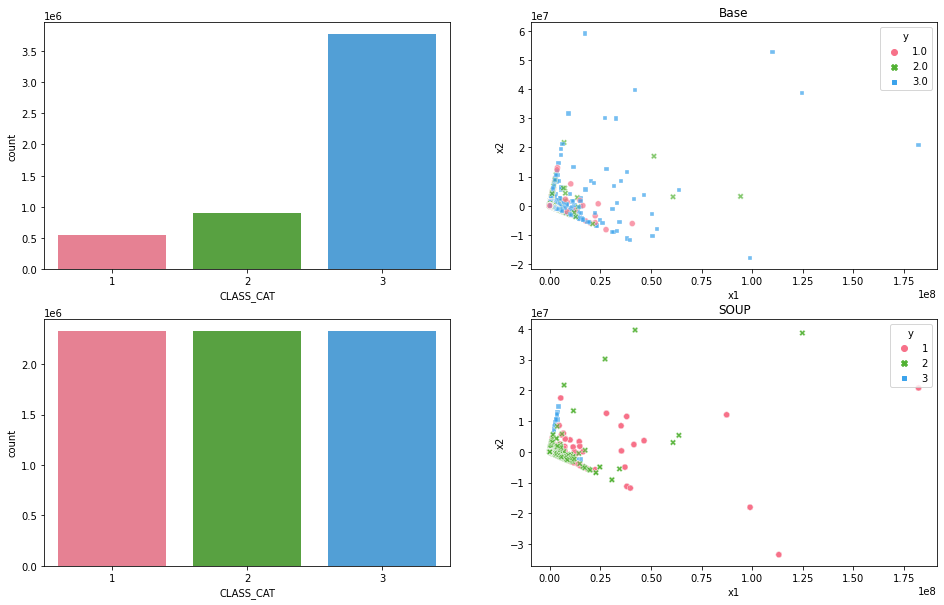

In [55]:
resampled_X, resampled_y = Similarity_Over_Under_samplig(X_train,Y_train)

## ■ (4) Hyper parameter estimate - RandseachCV

In [ ]:
# lgbm_best_param = HyperPram_RandseachCV(X_train, Y_train,'lgbm')

## ■ (5) Hyper parameter estimate - loop

In [17]:
lgm_param_grad = {'subsample':  [0.5,0.7],
                 'random_state': [123], 
                 'num_leaves':  np.array(range(200,500,100)).tolist(), 
                 'n_estimators': np.array(range(200,1500,100)).tolist(),
                 'min_split_gain': [0.01,0.05], 
                 'max_depth': np.array(range(10,60,10)).tolist(),
                 'learning_rate': [0.05], 
                 'boosting_type': ['gbdt'],
                 'n_jobs' : [10]}

params = list(dict_product(lgm_param_grad))

for i in range(2,len(params)):
    print('INDEX : %s / %s '%(i,len(params)))
    boosting_clf_loop(X_train, Y_train['CLASS_CAT'], X_test, Y_test['CLASS_CAT'],params[i],'LGBM','OVA')


## ■ Modeling

### Partial Classifier

In [22]:
#■ Sampling을 사용할경우 주석해제 (resampled_X ,resampled_y)
# X_train = resampled_X
# Y_train = resampled_y
mdl_input_feature = feature_x
multicat = 'SOUP'
cat      = 'LGBM'
title    = 'LAST'
print('Boosting_clf')
check_pid()
start = time.time()

# lgbm_best_param = {}
model_make_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
if cat == 'XGB':
    clf = XGBClassifier(**lgbm_best_param)
elif cat == 'LGBM':
#     clf = LGBMClassifier(**lgbm_best_param)
    clf = LGBMClassifier(boosting_type='gbdt',colsample_bytree=1.0,
                           importance_type='split', learning_rate=0.05, max_depth=50,
                           min_child_samples=30, min_child_weight=0.001,
                           min_split_gain=0.05, n_estimators=1400, n_jobs=20,
                           num_leaves=500, random_state=123, reg_alpha=0.0,
                           reg_lambda=0.0, silent=True, subsample=0.5,
                           subsample_for_bin=200000, subsample_freq=0,objective= 'multiclass')
#     evals = [(X_test,Y_test)]
clf.fit(X_train[mdl_input_feature],Y_train)
clf_str = str(clf)
ran_num = int(np.random.choice(1000000, 1))+len(str(clf))
col_len = len(X_train[mdl_input_feature].columns)
mdl_file_nm = multicat+'_'+cat+'_'+title+'_'+str(col_len)+'_'+'Feature'
print('mld_file_nm : %s'%mdl_file_nm)
save_model(clf,mdl_file_nm)
y_pred      = clf.predict(X_test.reindex(columns=mdl_input_feature))
y_pred_prob = clf.predict_proba(X_test.reindex(columns=mdl_input_feature))
learn_time,train_time = timecheck(start)

Boosting_clf
■ [PID]          : 110628 
■ [Jupyter path] : /home/cdsadmin/python_src/EY/YSR/00.end_version
■ [Kernel ID]    : 4b50f830-032e-4ffa-8d80-81dbda81919a


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=50,
               min_child_samples=30, min_child_weight=0.001,
               min_split_gain=0.05, n_estimators=1400, n_jobs=20,
               num_leaves=500, objective=None, random_state=123, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=0)

mld_file_nm : SOUP_LGBM_LAST_42_Feature
/home/cdsadmin/AMT/src/model/timing/ 경로에 SOUP_LGBM_LAST_42_Feature.pkl 모델 저장완료 


'SOUP_LGBM_LAST_42_Feature'

소요시간 : 620.0 초   ( 10 분 )



In [40]:
db_data =    {'MODEL_KEY'           : [1],
              'DATE_TIME'           : [model_make_date],
              'TRAIN_TIME'          : [train_time],
              'OVO_OVA'             : ['OVA'],
              'ML'                  : [clf_str.split("(")[0]],
              'HYPER_PARAM'         : [clf_str.split("(")[1]],
              'FEATURE_LIST'        : [str(mdl_input_feature)],
              'SAMPLING'            : ['SOUP'], 
              'TRAIN_SET'           : [len(X_train)],
              'TEST_SET'            : [len(X_test)],  
              'C1_CNT'              : [len(Y_train[Y_train == 1])],
              'C2_CNT'              : [len(Y_train[Y_train == 2])],
              'C3_CNT'              : [len(Y_train[Y_train == 3])],
              'C1_TRAIN_CNT'        : [len(Y_train[Y_train == 1])],
              'C2_TRAIN_CNT'        : [len(Y_train[Y_train == 2])],
              'C3_TRAIN_CNT'        : [len(Y_train[Y_train == 3])],
              'C1_TEST_cnt'         : [len(Y_test[Y_test == 1])],
              'C2_TEST_cnt'         : [len(Y_test[Y_test == 2])],
              'C3_TEST_cnt'         : [len(Y_test[Y_test == 3])],
              'MODEL_DIR'           : [mdl_file_nm],
              'CLASS_CAT'           : [1],
              'PRED_TARGET_CNT'     : [1],
              'PRED_NONTARGET_CNT'  : [1],
              'TN'                  : [1],
              'TP'                  : [1],
              'FN'                  : [1],
              'FP'                  : [1],
              'ACCURACY'            : [1],
              'PRECISION'           : [1], 
              'RECALL'              : [1],
              'FPR'                 : [1],
              'F1_SCORE'            : [1],
              'PRC_AUC'             : [1],
              'ROC_AUC'             : [1]}


model_score(y_test = Y_test,y_pred = y_pred ,y_pred_prob = y_pred_prob,db_data = db_data,sampling = 'SOUP')

thresholds : [1.99998746e+00 9.99987462e-01 9.99953067e-01 ... 9.24853238e-04
 9.24832695e-04 5.42996175e-16]
============================= Multiclass Classifier =========================
CLASS : 1 
==============================   ACCURACY  =================================
ACCURACY : 0.93%
==============================   COUNT DATA   ==============================
C1_Count : 137572
C2_Count : 224437
C3_Count : 941633
C1_test_Count : 137572
C1_pred_Count : 135848
===========================   Confusion Matrix   ===========================
[[1122214   43856]
 [  45580   91992]]
TN : 1122214
TP : 91992
FN : 45580
FP : 43856
=========================   Precision / Recall   ===========================
precision_rate : 0.68 (TP+/TP+FP)
recall_rate : 0.67 (TP+/TP+FN)
=============================   F1 SCORE   =================================
f1_score :  0.67 (2*((precision * recall)/(precision+recall)))
================================   AUC_SCORE  ==============================
AUC_SCORE

,MODEL_KEY,DATE_TIME,TRAIN_TIME,OVO_OVA,ML,HYPER_PARAM,FEATURE_LIST,SAMPLING,TRAIN_SET,TEST_SET,...,TP,FN,FP,ACCURACY,PRECISION,RECALL,FPR,F1_SCORE,PRC_AUC,ROC_AUC
0,SOUP_LGBM_LAST_42_Feature_1,2021-03-10 13:19:55,10,OVA,LGBMClassifier,"boosting_type='gbdt', class_weight=None, colsa...","['TOT_FREQUENCY_CNT', 'RFM_LV', 'RFM_F_SCORE',...",SOUP,5214565,1303642,...,91992,45580,43856,0.931395,0.677169,0.668683,0.03761,0.672899,0.762976,0.965416


thresholds : [1.99779771e+00 9.97797708e-01 9.96235546e-01 ... 4.11314465e-05
 4.11297617e-05 1.39272820e-13]
============================= Multiclass Classifier =========================
CLASS : 2 
==============================   ACCURACY  =================================
ACCURACY : 0.85%
==============================   COUNT DATA   ==============================
C1_Count : 137572
C2_Count : 224437
C3_Count : 941633
C2_test_Count : 224437
C2_pred_Count : 180534
===========================   Confusion Matrix   ===========================
[[1002174   77031]
 [ 120934  103503]]
TN : 1002174
TP : 103503
FN : 120934
FP : 77031
=========================   Precision / Recall   ===========================
precision_rate : 0.57 (TP+/TP+FP)
recall_rate : 0.46 (TP+/TP+FN)
=============================   F1 SCORE   =================================
f1_score :  0.51 (2*((precision * recall)/(precision+recall)))
================================   AUC_SCORE  ==============================
AUC_SCO

,MODEL_KEY,DATE_TIME,TRAIN_TIME,OVO_OVA,ML,HYPER_PARAM,FEATURE_LIST,SAMPLING,TRAIN_SET,TEST_SET,...,TP,FN,FP,ACCURACY,PRECISION,RECALL,FPR,F1_SCORE,PRC_AUC,ROC_AUC
0,SOUP_LGBM_LAST_42_Feature_2,2021-03-10 13:19:55,10,OVA,LGBMClassifier,"boosting_type='gbdt', class_weight=None, colsa...","['TOT_FREQUENCY_CNT', 'RFM_LV', 'RFM_F_SCORE',...",SOUP,5214565,1303642,...,103503,120934,77031,0.848145,0.573316,0.461167,0.071378,0.511163,0.596701,0.891961


thresholds : [2.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.46993290e-05
 3.46799927e-05 5.87315550e-07]
============================= Multiclass Classifier =========================
CLASS : 3 
==============================   ACCURACY  =================================
ACCURACY : 0.88%
==============================   COUNT DATA   ==============================
C1_Count : 137572
C2_Count : 224437
C3_Count : 941633
C3_test_Count : 941633
C3_pred_Count : 987260
===========================   Confusion Matrix   ===========================
[[260387 101622]
 [ 55995 885638]]
TN : 260387
TP : 885638
FN : 55995
FP : 101622
=========================   Precision / Recall   ===========================
precision_rate : 0.90 (TP+/TP+FP)
recall_rate : 0.94 (TP+/TP+FN)
=============================   F1 SCORE   =================================
f1_score :  0.92 (2*((precision * recall)/(precision+recall)))
================================   AUC_SCORE  ==============================
AUC_SCORE : 

,MODEL_KEY,DATE_TIME,TRAIN_TIME,OVO_OVA,ML,HYPER_PARAM,FEATURE_LIST,SAMPLING,TRAIN_SET,TEST_SET,...,TP,FN,FP,ACCURACY,PRECISION,RECALL,FPR,F1_SCORE,PRC_AUC,ROC_AUC
0,SOUP_LGBM_LAST_42_Feature_3,2021-03-10 13:19:55,10,OVA,LGBMClassifier,"boosting_type='gbdt', class_weight=None, colsa...","['TOT_FREQUENCY_CNT', 'RFM_LV', 'RFM_F_SCORE',...",SOUP,5214565,1303642,...,885638,55995,101622,0.879095,0.897067,0.940534,0.280717,0.918286,0.982413,0.952606


              precision    recall  f1-score   support

           1      0.677     0.669     0.673    137572
           2      0.573     0.461     0.511    224437
           3      0.897     0.941     0.918    941633

    accuracy                          0.829   1303642
   macro avg      0.716     0.690     0.701   1303642
weighted avg      0.818     0.829     0.822   1303642



## ■ (5) Feature Importance 

In [29]:
soup_df = pd.concat([resampled_X,resampled_Y],axis=1)

In [42]:
LGB_clf         = load_model(MODEL_NAME)
# XGB_clf         = XGBClassifier(n_jobs= 5)

# sfm_feature_list = selectfrommodel_importance(last_df,last_feature)
# c1_df    = last_df.loc[last_df['CLASS_CAT'].isin([1,4]),key_x+last_feature]
# c2_df    = last_df.loc[last_df['CLASS_CAT'].isin([2,4]),key_x+last_feature]
# c3_df    = last_df.loc[last_df['CLASS_CAT'].isin([3,4]),key_x+last_feature]
# c2_c3_df = last_df.loc[last_df['CLASS_CAT'].isin([2,3]),key_x+last_feature]
# c1_c2_df = last_df.loc[last_df['CLASS_CAT'].isin([1,2]),key_x+last_feature]
# c1_c3_df = last_df.loc[last_df['CLASS_CAT'].isin([1,3]),key_x+last_feature]

# Feature_Importance(LGB_clf,df,cols)
# c1_result      = Feature_Importance(LGB_clf,c1_df,last_feature,'C1 VS C4')
# c2_result      = Feature_Importance(LGB_clf,c2_df,last_feature,'C2 VS C4')
# c3_result      = Feature_Importance(LGB_clf,c3_df,last_feature,'C3 VS C4')
# c2_c3_result = Feature_Importance(LGB_clf,c2_c3_df,last_feature,'C2 VS C3')
# c1_c2_result = Feature_Importance(LGB_clf,c1_c2_df,last_feature,'C1 VS C2')
# c1_c3_result = Feature_Importance(LGB_clf,c1_c3_df,last_feature,'C1 VS C3')

# last_df             = input_df[key_x+last_feature]
# c1_f = lambda x: 1 if x == 1 else 0
# c1_all_result = Feature_Importance(LGB_clf,soup_df,last_feature,'C1 VS ALL (SOUP Sampling)',c1_f)

# c2_f = lambda x: 1 if x == 2 else 0
# c2_all_result = Feature_Importance(LGB_clf,soup_df,last_feature,'C2 VS ALL (SOUP Sampling)',c2_f)

# c3_f = lambda x: 1 if x == 3 else 0
# c3_all_result = Feature_Importance_test(LGB_clf,soup_df,last_feature,'C3 VS ALL (SOUP Sampling)',c3_f)

# c4_f = lambda x: 1 if x == 4 else 0
# c4_all_result = Feature_Importance(LGB_clf,last_df,last_feature,'C4 VS ALL',c4_f)

# ================================================================

In [53]:
LGB_clf.booster_.feature_importance(importance_type='gain')
LGB_clf.booster_.feature_name()

array([2.14009391e+07, 2.02998868e+05, 2.53677122e+05, 2.32587913e+05,
       4.68434095e+05, 4.06492534e+05, 5.88231895e+06, 1.16999110e+07,
       3.52056320e+05, 8.28419573e+03, 1.33423850e+05, 4.71547237e+05,
       3.55075649e+05, 5.52438492e+05, 2.42804375e+03, 4.22455118e+04,
       6.63164397e+04, 5.80023212e+04, 2.24139223e+05, 6.61733842e+06,
       4.79118358e+05, 3.67715875e+05, 3.40205531e+05, 3.94308006e+05,
       3.46943899e+05, 3.52900134e+05, 1.01958270e+05, 2.61671610e+05,
       3.36339178e+05, 2.61774983e+05, 2.80607776e+05, 1.21474718e+05,
       3.38525765e+05, 6.42386819e+04, 3.53634255e+04, 1.90684719e+04,
       7.02581287e+04, 2.32682146e+04, 1.80462366e+04, 4.67920945e+03,
       8.46440925e+03, 9.62185753e+03])

['TOT_FREQUENCY_CNT',
 'RFM_LV',
 'RFM_F_SCORE',
 'RFM_M_SCORE',
 'DAVG_PURCHS_AMT_EXC_ELEC',
 'RECENT_3M_FREQUENCY_DIFF_RT',
 'PURCHS_CYCLE',
 'PURCHS_CYCLE_ARRVL_RT',
 'PURCHS_CYCLE_CHG',
 'PURCHS_CYCLE_REGUL_YN',
 'PURCHS_VISIT_CHG_RT_AVG_6M',
 'TOP1_STR_DSTNC',
 'TOP2_STR_DSTNC',
 'USEFL_POINT',
 'EMT_MALL_VISIT_YN',
 'EMT_MALL_LAST_PUCHS_DIFF',
 'LAST_ONLINE_DIFF_DAYS',
 'LAST_OFFLINE_DIFF_DAYS',
 'LAST_OFFLINE_BIZTP_DIFF_DAYS',
 'RECENT_1M_SALES_INDEX',
 'RFM_LV_DI_FRESH1',
 'RFM_LV_DI_FRESH2',
 'RFM_LV_DI_PEACOCK',
 'RFM_LV_DI_PRCS',
 'RFM_LV_DI_HNR',
 'RFM_LV_DI_LIVING',
 'RFM_LV_DI_MOLLYS',
 'RFM_LV_DI_ELEC_CULTR',
 'RFM_LV_DI_FSHN',
 'MAIN_PRDT_ARRVL_RT_DIFF_ABS',
 'PREFER_PRDT_ARRVL_RT_DIFF_ABS',
 'MIN_PRDT_PURCHS_CYCLE',
 'MAX_PRDT_PURCHS_CYCLE',
 'PRDT_DCODE10_CNT',
 'PRDT_DCODE11_CNT',
 'PRDT_DCODE20_CNT',
 'PRDT_DCODE30_CNT',
 'PRDT_DCODE40_CNT',
 'PRDT_DCODE41_CNT',
 'PRDT_DCODE42_CNT',
 'PRDT_DCODE50_CNT',
 'PRDT_DCODE60_CNT']

## ■ Sqlite (DB연결)

In [8]:
sql = '''
        SELECT MODEL_DIR,max(SUBSTR(DATE_TIME,1,10))AS DATE_TIME,AVG(RECALL) AS RECALL, AVG(PRECISION) AS PRECISION,AVG(F1_SCORE) AS F1_SCORE
        FROM YSR_ML_VALIDATION_TABLE
        GROUP BY MODEL_DIR
       '''
# sql2 = '''SELECT * FROM YSR_PI_RESULT  '''
t1 = select_table(sql2)
setable = select_table('''select * from YSR_ML_VALIDATION_TABLE ORDER BY DATE_TIME DESC''')

ml_list_2 = select_table('''SELECT DISTINCT MODEL_DIR,HYPER_PARAM,FEATURE_LIST 
                            FROM YSR_ML_VALIDATION_TABLE 
                            WHERE MODEL_DIR = 'OVA_LGBM_58_900524' ''')


OperationalError: no such table: YSR_PI_RESULT

In [44]:
setable.iloc[0:3]

,MODEL_KEY,DATE_TIME,TRAIN_TIME,OVO_OVA,ML,HYPER_PARAM,FEATURE_LIST,SAMPLING,TRAIN_SET,TEST_SET,C1_CNT,C2_CNT,C3_CNT,C1_TRAIN_CNT,C2_TRAIN_CNT,C3_TRAIN_CNT,C1_TEST_cnt,C2_TEST_cnt,C3_TEST_cnt,MODEL_DIR,CLASS_CAT,PRED_TARGET_CNT,PRED_NONTARGET_CNT,TN,TP,FN,FP,ACCURACY,PRECISION,RECALL,FPR,F1_SCORE,PRC_AUC,ROC_AUC
0,SOUP_LGBM_TOP5_MODEL_6_538824_1,2021-01-12 23:18:30,7,OVA,LGBMClassifier,"boosting_type='gbdt', class_weight=None, colsa...","['DAVG_PURCHS_AMT_EXC_ELEC', 'PURCHS_CYCLE', '...",SOUP,6725649,1302902,6725649,6725649,6725649,6725649,6725649,6725649,182679,213326,906897,SOUP_LGBM_TOP5_MODEL_6_538824,1,251432,1051470,1020261,151470,31209,99962,0.899324,0.602429,0.829159,0.089234,0.697840,0.779346,0.957986
1,SOUP_LGBM_TOP5_MODEL_6_538824_2,2021-01-12 23:18:30,7,OVA,LGBMClassifier,"boosting_type='gbdt', class_weight=None, colsa...","['DAVG_PURCHS_AMT_EXC_ELEC', 'PURCHS_CYCLE', '...",SOUP,6725649,1302902,6725649,6725649,6725649,6725649,6725649,6725649,182679,213326,906897,SOUP_LGBM_TOP5_MODEL_6_538824,2,386539,916363,840573,137536,75790,249003,0.750716,0.355814,0.644722,0.228532,0.458557,0.466798,0.836873
2,SOUP_LGBM_TOP5_MODEL_6_538824_3,2021-01-12 23:18:30,7,OVA,LGBMClassifier,"boosting_type='gbdt', class_weight=None, colsa...","['DAVG_PURCHS_AMT_EXC_ELEC', 'PURCHS_CYCLE', '...",SOUP,6725649,1302902,6725649,6725649,6725649,6725649,6725649,6725649,182679,213326,906897,SOUP_LGBM_TOP5_MODEL_6_538824,3,664931,637971,387167,656093,250804,8838,0.800720,0.986708,0.723448,0.022318,0.834815,0.976526,0.943668


In [32]:
load_model('OVA_LGBM_58_842.pkl')
# load_model('OVA_LGBM_58_9551.pkl')
# load_model('OVA_LGBM_58_4611.pkl')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=50,
               min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.05, n_estimators=1450, n_jobs=10,
               num_leaves=400, objective=None, random_state=123, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

## multiclass - Confusion Matrix(Error)

OVA_LGBM_58_900524
■ model name :  OVA_LGBM_58_900524.pkl
■ Feature List(len :58) :  
 ['RFM_LV_DI_FRESH2', 'LAST_OFFLINE_DIFF_DAYS', 'SHOP_SEG_5', 'PURCHS_CYCLE_CHG', 'PRDT_DCODE42_CNT', 'PRDT_DCODE60_CNT', 'EMT_MALL_LAST_PUCHS_DIFF', 'PRDT_DCODE40_CNT', 'AVG_RECENT_1M_SALES_AMT', 'PRDT_DCODE11_CNT', 'TOT_RECENT_1M_FREQUENCY_CNT', 'PRDT_DCODE10_CNT', 'RFM_LV_DI_FASHION', 'PRDT_DCODE30_CNT', 'RECENT_1M_SALES_INDEX', 'PURCHS_CYCLE', 'RFM_LV_DI_MOLLYS', 'RFM_LV_DI_CULTR', 'SHOP_SEG_10', 'MAX_PRDT_PURCHS_CYCLE', 'MAIN_PRDT_ARRVL_RT_DIFF_ABS', 'PRDT_DCODE41_CNT', 'RFM_LV_DI_PEACOCK', 'PREFER_PRDT_ARRVL_RT_DIFF_ABS', 'SHOP_SEG_4', 'EMT_MALL_VISIT_YN', 'PRDT_DCODE70_CNT', 'RFM_LV_DI_HNB', 'TOT_FREQUENCY_CNT', 'PRDT_DCODE50_CNT', 'SHOP_SEG_2', 'PURCHS_CYCLE_ARRVL_DIFF_ABS', 'RFM_LV_DI_FRESH1', 'PURCHS_CYCLE_ARRVL_RT', 'MIN_PRDT_PURCHS_CYCLE', 'TOP2_STR_DSTNC', 'PRDT_DCODE20_CNT', 'SHOP_SEG_8', 'SHOP_SEG_3', 'RFM_LV_DI_ELEC', 'PURCHS_CYCLE_REGUL_YN', 'RFM_M_SCORE', 'LAST_OFFLINE_BIZTP_DIFF_DAY

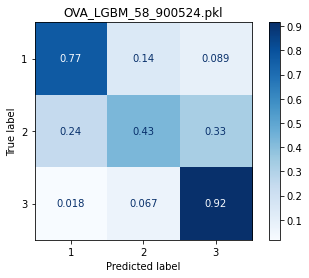

In [70]:
def confusion_matrix_error(X_test,Y_test,y_pred,y_pred_prob,mdl_nm,input_feature):
    model = load_model(mdl_nm)
    disp  = plot_confusion_matrix(model,X_test,Y_test,cmap=plt.cm.Blues,normalize='true')
    title = mdl_nm
    disp.ax_.set_title(title)
#     print('■ Feature List : \n %s' % input_feature)
#     print('■ model name : ',mdl_nm)
    print(classification_report(Y_test, y_pred, digits=3))
    print(disp.confusion_matrix)
    confusion_matrix(Y_test,y_pred)
    
# sample_mdl_list = ml_list_2.loc[setable['MODEL_DIR'].isin(['OVA_LGBM_58_7459'])]
sample_mdl_list = ml_list_2

for i in range(0,len(sample_mdl_list)):
    MM = sample_mdl_list.loc[i,'MODEL_DIR']
    print(MM)
    model_nm   = str(MM)+str('.pkl')
    colum_list = sample_mdl_list.loc[i,'FEATURE_LIST']
    x = ast.literal_eval(colum_list)
    feature = [n.strip() for n in x]
    print('■ model name : ',model_nm)
    print('■ Feature List(len :%s) :  \n %s' % (len(feature),feature))
    clf         = load_model(model_nm)
    X_test_2    = X_test.reindex(columns=feature)
    y_pred      = clf.predict(X_test_2)
    y_pred_prob = clf.predict_proba(X_test_2)
#
    confusion_matrix_error(X_test_2,Y_test['CLASS_CAT'],y_pred,y_pred_prob,model_nm,feature)

# confusion_matrix_error(X_test,Y_test,str(model_list[1])+str('.pkl'),'lgb')
# confusion_matrix_error(X_test,Y_test,str(model_list[2])+str('.pkl'),'xgb')
# confusion_matrix_error(X_test,Y_test,str(model_list[3])+str('.pkl'),'nb')